#Setup Commands

##Mount Google Drive

In [ ]:
# I guess this means I used colab ¯\_(ツ)_/¯
from google.colab import drive
drive.mount('/content/drive')

##Install ptflops

In [ ]:
!pip install ptflops

##Clone Book's Repo

In [ ]:
!git clone https://github.com/deep-learning-with-pytorch/dlwpt-code.git

#Problem 1

Lots of boilerplate taken from: https://pytorch.org/hub/pytorch_vision_resnet/

## Get imports and model ready

In [ ]:
import torch
from PIL import Image
from torchvision import transforms

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)

#Set the model to evaluation mode
model.eval()

##Load, Pre-Process and classify the five images

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Define preproccessor for resnet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the filenames so we can iterate over them
filenames = ["barf.jpg","cats-themovie.jpeg","Dachshunds.jpg","tabbycat.jpg","yogurt.jpg"]

# Loop through each file and classify it
for filename in filenames:
  input_image = Image.open("/content/drive/MyDrive/Documents/School/AI/Homework 0/images/Problem 1/" + filename)
  image = preprocess(input_image)
  
  # Make the mini-batch
  input_batch = image.unsqueeze(0)

  # See if there is a GPU to use, if so use it
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  # Disable the gradient since we aren't training
  with torch.no_grad():
      output = model(input_batch)

  probabilities = torch.nn.functional.softmax(output[0], dim=0)

  # Read the categories
  with open("imagenet_classes.txt", "r") as f:
      categories = [s.strip() for s in f.readlines()]
  # Show top categories
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  print()
  print("Getting top categories for: " + filename)
  print()
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]], top5_prob[i].item())

--2022-01-28 00:40:12--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.7’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-01-28 00:40:12 (67.0 MB/s) - ‘imagenet_classes.txt.7’ saved [10472/10472]


Getting top categories for: barf.jpg

wig 0.49145546555519104
mask 0.12396349757909775
Band Aid 0.08378460258245468
hair spray 0.03912839666008949
stage 0.022198399528861046

Getting top categories for: cats-themovie.jpeg

fur coat 0.7540560364723206
feather boa 0.16521547734737396
cloak 0.01780361495912075
crutch 0.007342464756220579
wig 0.004194934852421284

Getting top categories for: Dachsh

# Problem 2

In [ ]:
# Obligatory reset button
%reset

## Setup ResNetGen
*Model definition obviously taken from [here](https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch2/3_cyclegan.ipynb)*



In [ ]:
import torch
import torch.nn as nn

from PIL import Image
from torchvision import transforms

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

Create the generator network and set it to evaluation mode

In [ ]:
netG = ResNetGenerator()

model_path = '/content/dlwpt-code/data/p1ch2/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

netG.eval()

Preprocess each image and generate our zebras

In [ ]:
# Removed the cropping this go round, since we're not just dealing with plain ol' squares
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the filenames so we can iterate over them
filenames = ["closeup.jpg","horse.jpg","horses.jpg","stuffed-horse.jpg","white-horse.jpg"]


# Loop through each file and classify it
for filename in filenames:
  input_image = Image.open("/content/drive/MyDrive/Documents/School/AI/Homework 0/images/Problem 2/" + filename)
  image = preprocess(input_image)
  print(image.size())
  batch = torch.unsqueeze(image, 0)

  # See if there is a GPU to use, if so use it
  if torch.cuda.is_available():
      batch = batch.to('cuda')
      netG.to('cuda')

  batchOut = netG(batch)
  
  outImage = (batchOut.data.squeeze() + 1.0) / 2.0
  outImg = transforms.ToPILImage()(outImage)
  outImg.save("zebra-" + filename)

torch.Size([3, 256, 455])
torch.Size([3, 256, 384])
torch.Size([3, 256, 532])
torch.Size([3, 256, 256])
torch.Size([3, 256, 369])


## Commands for displaying the various creations

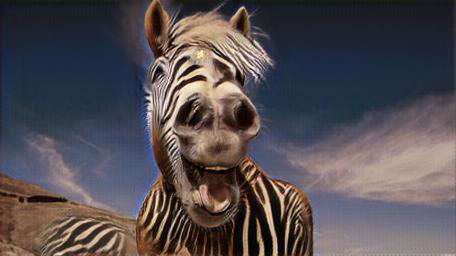

In [ ]:
closeup = Image.open("zebra-closeup.jpg")

closeup

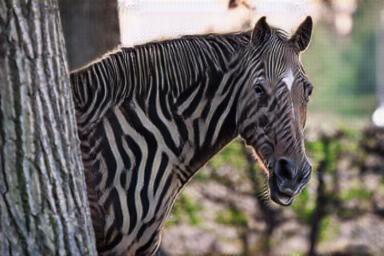

In [ ]:
horse = Image.open("zebra-horse.jpg")

horse

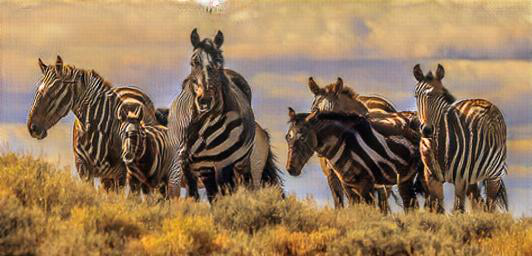

In [ ]:
horses = Image.open("zebra-horses.jpg")

horses

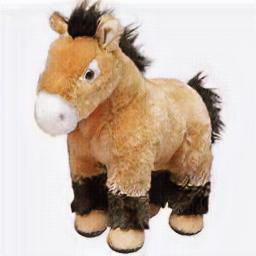

In [ ]:
stuffedHorse = Image.open("zebra-stuffed-horse.jpg")

stuffedHorse

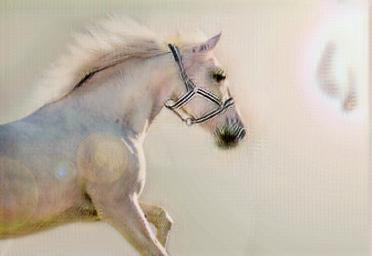

In [ ]:
whiteHorse = Image.open("zebra-white-horse.jpg")

whiteHorse

#Problem 3
*Time to rehash old problems*

In [ ]:
# Obligatory reset button
%reset

## MACs for Problem 1


###Setup Imports and Model

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
from ptflops import get_model_complexity_info

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)

#Set the model to evaluation mode
model.eval()

### Get the MACs using get_model_complexity_info



In [ ]:
# Get the macs for a 3x224x224 image since that's what we use in Problem 1.
macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       7.85 GMac
Number of parameters:           44.55 M 


## MACs for Problem 2

### Setup Imports and Model

In [ ]:
import torch
import torch.nn as nn

from PIL import Image
from torchvision import transforms
from ptflops import get_model_complexity_info

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

# Load the model and don't bother with weights since we don't need them
netG = ResNetGenerator()

netG.eval()

###Get the MACs using get_model_complexity_info


In [ ]:
# Get the macs for a 3x224x224 image here as well, to get a standard number
print("Stats for 224x224x3")
macs, params = get_model_complexity_info(netG, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))
print()
print("Stats for 532x256x3")
# Get the maximum image size we actually feed the network, since we don't crop
macs, params = get_model_complexity_info(netG, (3, 256, 532), as_strings=True,
                                           print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Stats for 224x224x3
Computational complexity:       43.55 GMac
Number of parameters:           11.38 M 

Stats for 532x256x3
Computational complexity:       118.22 GMac
Number of parameters:           11.38 M 


#Problem 4

## Get imports and model ready

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
from ptflops import get_model_complexity_info

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

#Set the model to evaluation mode
model.eval()

##Load, Pre-Process and classify the five images

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Define preproccessor for resnet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the filenames so we can iterate over them
filenames = ["barf.jpg","cats-themovie.jpeg","Dachshunds.jpg","tabbycat.jpg","yogurt.jpg"]

# Loop through each file and classify it
for filename in filenames:
  input_image = Image.open("/content/drive/MyDrive/Documents/School/AI/Homework 0/images/Problem 1/" + filename)
  image = preprocess(input_image)
  
  # Make the mini-batch
  input_batch = image.unsqueeze(0)

  # See if there is a GPU to use, if so use it
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  # Disable the gradient since we aren't training
  with torch.no_grad():
      output = model(input_batch)

  probabilities = torch.nn.functional.softmax(output[0], dim=0)

  # Read the categories
  with open("imagenet_classes.txt", "r") as f:
      categories = [s.strip() for s in f.readlines()]
  # Show top categories
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  print()
  print("Getting top categories for: " + filename)
  print()
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]], top5_prob[i].item())

--2022-01-28 00:46:25--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.8’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-01-28 00:46:25 (93.8 MB/s) - ‘imagenet_classes.txt.8’ saved [10472/10472]


Getting top categories for: barf.jpg

Band Aid 0.16013076901435852
wig 0.1555040031671524
sweatshirt 0.10069171339273453
hair spray 0.04284602031111717
jersey 0.027316473424434662

Getting top categories for: cats-themovie.jpeg

fur coat 0.5530843734741211
wig 0.19626832008361816
feather boa 0.11119744181632996
cloak 0.009119793772697449
affenpinscher 0.005226504057645798

Getting top categorie

##Get the model size and MACs

In [ ]:
# Get the macs for a 3x224x224 image since that's what we use in Problem 1.
macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.32 GMac
Number of parameters:           3.5 M   
